<a href="https://colab.research.google.com/github/Vj-Ydv/thesis_work/blob/main/Timesofindia_LSTM_Train_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This cell connects to google drive, authenticates connection, and iterates over file list displaying each file's title and ID.
# it also imports and installs all the necessary libraries
!pip install -U -q PyDrive
!pip install -U -q wordcloud
!pip install -U -q bokeh
!pip install textblob
!pip install sklearn

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from scipy.stats import hmean
from scipy.stats import norm
from pylab import *
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from time import time

  

     |████████████████████████████████| 435 kB 5.2 MB/s 
     |████████████████████████████████| 18.5 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
panel 0.12.1 requires bokeh<2.4.0,>=2.3.0, but you have bokeh 2.4.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


# **Data Preprocessing**

In [4]:
df_train = pd.read_csv('Dataset_For_Project/timesofindia_with_topic_12.csv', encoding='latin-1')
df_train

,target,text,Topic
0,Negative,MP to study new Motor Act before implementing ...,7
1,Negative,Bhujbal says higher power rate driving industr...,4
2,Negative,Mandira Bedi shares a monochrome picture in a ...,0
3,Negative,Harassment in office DM seeks action taken re...,8
4,Negative,Two students end their lives mumbai,9
...,...,...,...
63075,Positive,Going to India Gate tonight? You could be in f...,6
63076,Positive,40;000 cops to ensure safe New Year celebratio...,10
63077,Positive,Ten more private trains from Mumbai on cards m...,2
63078,Positive,A trip to a tribal village with super cop Vija...,3


In [5]:
#Strips emojis
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :'),:D, : D, =)
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))|:\s?D | =\)', '', tweet)
    # Sad -- :-(, : (, :(, ):, )-: , :p
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)|:p', '', tweet)
    return tweet
  

In [6]:
#clean data
url = re.compile(r"(?:(http[s]?://\S+)|((//)?(\w+\.)?\w+\.\w+/\S+))")
user_mention = re.compile(r"(?:(?<!\w)@\w+\b)")
number = re.compile(r"(?:\b\d+\b)")
repeated_char = '([a-zA-Z])\\1+'
length_repeated_char = '\\1\\1'

def clean(raw):
  #convert HTML encoding to text
  new_row = BeautifulSoup(raw, 'html.parser').get_text()
  
  #Change all text to lower case
  new_row = new_row.lower()
  
  #Replaces any url with class URL
  new_row = re.sub(url, '', new_row)
  
  #replace any @username with class USERNAME
  new_row = re.sub(user_mention, '', new_row)
  
  #Strips repeated chars
  new_row = re.sub(repeated_char, length_repeated_char, new_row)
  
  #Replaces #hashtag with hashtag
  new_row = re.sub(r'#(\S+)', r' \1 ', new_row)
  
  #Remove numbers
  new_row = re.sub(number, '', new_row)
  
  #decode text with 'utf-8-sig'
  try:
    temp_row = new_row.decode("utf-8-sig").replace(u"\ufffd", "?")     
  except:
    temp_row = new_row
  
  #Removes emojis
  new_row = handle_emojis(temp_row);
  
  return new_row

In [8]:
# upload file into pandas dataframe and drop unnecessary columns and neutral rows

# Using columns 1,2 because col 0 is the number of the row, could be changed if the row number is removed from the csv file.
df_train = pd.read_csv('Dataset_For_Project/timesofindia_with_topic_12.csv', encoding='latin-1')
df_train.head()

,target,text,Topic
0,Negative,MP to study new Motor Act before implementing ...,7
1,Negative,Bhujbal says higher power rate driving industr...,4
2,Negative,Mandira Bedi shares a monochrome picture in a ...,0
3,Negative,Harassment in office DM seeks action taken re...,8
4,Negative,Two students end their lives mumbai,9


In [11]:
df_news=pd.read_csv('Dataset_For_Project/timesofindia_with_topic_12.csv', usecols=[1,2], encoding='utf-8')
df_news

,text,Topic
0,MP to study new Motor Act before implementing ...,7
1,Bhujbal says higher power rate driving industr...,4
2,Mandira Bedi shares a monochrome picture in a ...,0
3,Harassment in office DM seeks action taken re...,8
4,Two students end their lives mumbai,9
...,...,...
63075,Going to India Gate tonight? You could be in f...,6
63076,40;000 cops to ensure safe New Year celebratio...,10
63077,Ten more private trains from Mumbai on cards m...,2
63078,A trip to a tribal village with super cop Vija...,3


# **Tweets Analysis**

In [12]:
df_news['Topic'].value_counts()

5     7282
0     6862
10    5787
8     5382
7     5245
9     5174
3     5063
11    4868
6     4736
2     4476
1     4159
4     4046
Name: Topic, dtype: int64

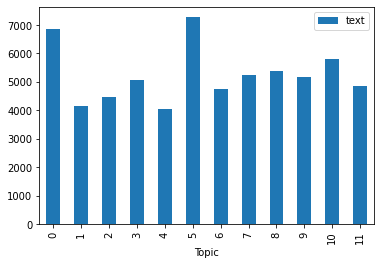

In [13]:
# The distribution of sentiments
df_news.groupby('Topic').count().plot(kind='bar')

In [14]:
import plotly.express as px

fig = px.pie(df_news, names='Topic', title ='Pie chart of different sentiments of tweets')
fig.show()

In [15]:

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df_news['text'][0])
print("\nProcessed tweet ->", tweet_to_words(df_news['text'][0]))


Original tweet -> MP to study new Motor Act before implementing it  CM Kamal Nath bhopal

Processed tweet -> ['mp', 'studi', 'new', 'motor', 'act', 'implement', 'cm', 'kamal', 'nath', 'bhopal']


In [17]:
X = list(map(tweet_to_words, df_news['text']))


In [18]:
from sklearn.preprocessing import LabelEncoder

# Encode Topic labels
le = LabelEncoder()
Y = le.fit_transform(df_news['Topic'])

In [19]:
print(X[0])
print(Y[0])

['mp', 'studi', 'new', 'motor', 'act', 'implement', 'cm', 'kamal', 'nath', 'bhopal']
7


In [20]:
y = pd.get_dummies(df_news['Topic'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) #split into test and validation set

In [21]:
#Bag of words (BoW) extraction

from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

In [22]:
# print first 200 words/tokens
print(count_vector.get_feature_names()[0:200])

['0', '000', '1', '10', '100', '108', '10th', '11', '112', '12', '120', '13', '14', '144', '15', '150', '16', '17', '18', '19', '1st', '2', '20', '200', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2024', '21', '22', '23', '24', '24x7', '25', '250', '26', '27', '28', '29', '2nd', '3', '30', '300', '31', '32', '33', '34', '35', '350', '36', '37', '370', '38', '39', '3d', '3rd', '4', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '49', '4th', '5', '50', '500', '51', '52', '53', '54', '55', '550th', '56', '57', '58', '5g', '5th', '6', '60', '600', '61', '62', '63', '64', '65', '66', '66th', '67', '68', '69', '7', '70', '700', '71', '72', '73', '74', '75', '76', '77', '78', '7th', '8', '80', '800', '81', '82', '83', '84', '85', '86', '87', '9', '90', '900', '91', '92', '94', '95', '96', '98', '99', 'aadhaar', 'aaditya', 'aai', 'aap', 'aarey', 'aaryan', 'aayog', 'abandon', 'abduct', 'abet', 'abhaya', 'abhijit', 'abhishek', 'abl', 'ablaz', 'ab

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df_news['text'][0])
X, tokenizer = tokenize_pad_sequences(df_news['text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 MP to study new Motor Act before implementing it  CM Kamal Nath bhopal
After Tokenization & Padding 
 [ 355    1  412   43 3061  324  342  108   90 1067 1156   79    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [24]:
#Saving tokenized data
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [25]:
y = pd.get_dummies(df_news['Topic'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (37848, 50) (37848, 12)
Validation Set -> (12616, 50) (12616, 12)
Test Set -> (12616, 50) (12616, 12)


In [26]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [32]:
# Bidirectional LSTM using NN
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 8000
embedding_size = 32
epochs=500
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(12, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



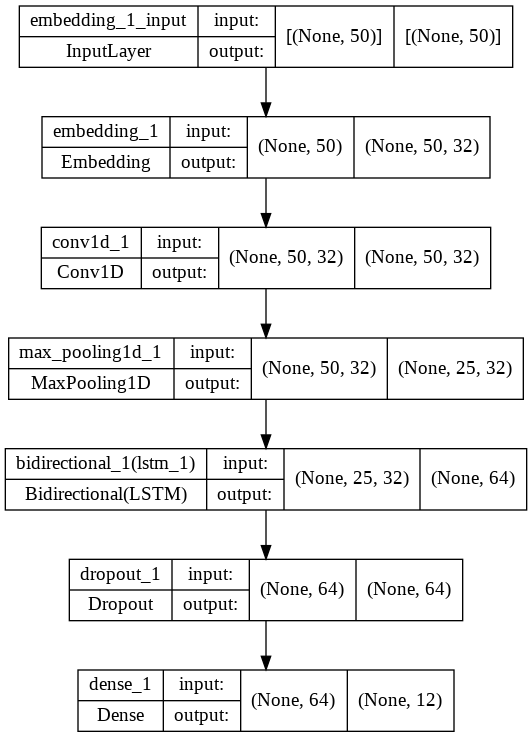

In [33]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [34]:
from keras import callbacks #callback function automatically stops looping/epochs when condition of accuracy or loss is met, in this case it is loss
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [35]:

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

In [36]:
history1 = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=64, epochs=500, callbacks =[earlystopping], verbose=1)

Epoch 1/500
592/592 [==============================] - 30s 42ms/step - loss: 2.2875 - accuracy: 0.1979 - precision_1: 0.7655 - recall_1: 0.0464 - val_loss: 1.9785 - val_accuracy: 0.3088 - val_precision_1: 0.8566 - val_recall_1: 0.1312
Epoch 2/500
592/592 [==============================] - 27s 45ms/step - loss: 1.8210 - accuracy: 0.3888 - precision_1: 0.8163 - recall_1: 0.2062 - val_loss: 1.6279 - val_accuracy: 0.4761 - val_precision_1: 0.8600 - val_recall_1: 0.2605
Epoch 3/500
592/592 [==============================] - 23s 40ms/step - loss: 1.5173 - accuracy: 0.5281 - precision_1: 0.8073 - recall_1: 0.3243 - val_loss: 1.3671 - val_accuracy: 0.5791 - val_precision_1: 0.8361 - val_recall_1: 0.3776
Epoch 4/500
592/592 [==============================] - 24s 40ms/step - loss: 1.2814 - accuracy: 0.6140 - precision_1: 0.8026 - recall_1: 0.4352 - val_loss: 1.2459 - val_accuracy: 0.6177 - val_precision_1: 0.7850 - val_recall_1: 0.4747
Epoch 5/500
592/592 [==============================] - 25s 4

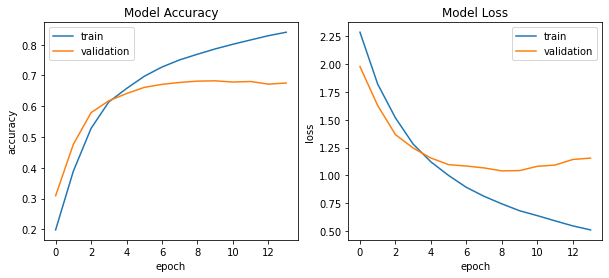

In [37]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history1)

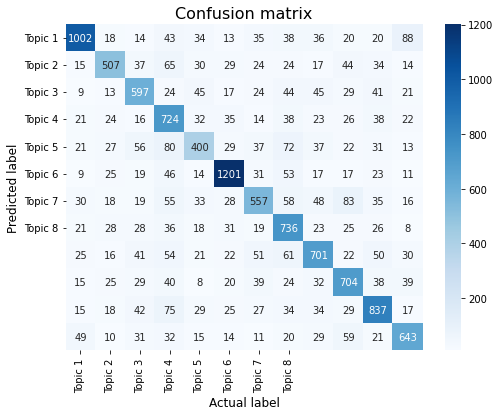

In [38]:
#Model confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [39]:
# Save the model architecture & the weights
model.save('timesofindia_lstm_model_for_topic.h5')
print('Best model saved')

Best model saved


# **Aspect based sentiment**

In [40]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
#For aspect based
def predict_aspect(text):
  # Importing the required libraries
  import spacy
  sp = spacy.load("en_core_web_sm")
  from textblob import TextBlob

  # Creating a list of positive and negative sentences.
  mixed_sen = [text]

  # An empty list for obtaining the extracted aspects
  # from sentences.
  ext_aspects = []

  # Performing Aspect Extraction
  for sen in mixed_sen:
    important = sp(sen)
    descriptive_item = ''
    Topic = ''
    for token in important:
      if token.dep_ == 'nsubj' and token.pos_ == 'NOUN':
        Topic = token.text
      if token.pos_ == 'ADJ':
        added_terms = ''
        for mini_token in token.children:
          if mini_token.pos_ != 'ADV':
            continue
          added_terms += mini_token.text + ' '
        descriptive_item = added_terms + token.text 
    ext_aspects.append({'aspect': Topic,'description': descriptive_item})

  print("ASPECT EXTRACTION\n")
  print(ext_aspects)


  for aspect in ext_aspects:
    aspect['sentiment'] = TextBlob(aspect['description']).sentiment

  print("\n")
  print("\nSENTIMENT ASSOCIATION\n")
  print(ext_aspects)


In [42]:
from keras.models import load_model

# Load model
model = load_model('timesofindia_lstm_model_for_topic.h5')

def predict_class(text):
    '''Function to predict Topic class of the passed text'''
    
    sentiment_classes = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted Topic is', sentiment_classes[yt[0]])

    

    #for apspect based sentiment prediction
    # converting list to string type
    str1 = " " 
    
    # return string  
    txt= str1.join(text)
    predict_aspect(txt)

   

## **Predicting**

In [43]:
predict_class(['The film has collected good box office collection'])


The predicted Topic is Topic 1
ASPECT EXTRACTION

[{'aspect': 'film', 'description': 'good'}]



SENTIMENT ASSOCIATION

[{'aspect': 'film', 'description': 'good', 'sentiment': Sentiment(polarity=0.7, subjectivity=0.6000000000000001)}]


In [47]:
predict_class(['Ram is the worst minister india'])

The predicted Topic is Topic 8
ASPECT EXTRACTION

[{'aspect': 'Ram', 'description': 'worst'}]



SENTIMENT ASSOCIATION

[{'aspect': 'Ram', 'description': 'worst', 'sentiment': Sentiment(polarity=-1.0, subjectivity=1.0)}]


In [45]:
predict_class(["i am feeling ill"])

The predicted Topic is Topic 2
ASPECT EXTRACTION

[{'aspect': '', 'description': 'ill'}]



SENTIMENT ASSOCIATION

[{'aspect': '', 'description': 'ill', 'sentiment': Sentiment(polarity=-0.5, subjectivity=1.0)}]
